In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
import cvxpy as cp
import pandas as pd

In [43]:
# Custom loss function
def compute_loss(X_0, X_1, a, b, t):
    # True Positives Lost (Class 1 points classified as Class 0)
    tp_lost = np.sum(a * X_1[:, 0] + b * X_1[:, 1] < t)
    
    # True Negatives Accepted (Class 0 points classified as Class 1)
    tn_accepted = np.sum(a * X_0[:, 0] + b * X_0[:, 1] >= t)
    
    # Loss is the sum of the penalties
    return tp_lost + tn_accepted 

# Calculate the movement vector for each selected point
def move_towards_boundary(X, mask, a, b, t):
    norm_factor = np.sqrt(a**2 + b**2)
    movement = np.outer((a * X[mask, 0] + b * X[mask, 1] - t) / norm_factor, np.array([a, b]) / norm_factor)
    X[mask] = X[mask] - movement

def plot_for(X_0, X_1, a, b, t, B, mode='NB', gamma=0.6):
    if mode == 'NB':
        # Calculate initial loss
        loss_initial = compute_loss(X_0, X_1, a, b, t)

        # Movement region parameters
        mask_0 = (t - B <= a * X_0[:, 0] + b * X_0[:, 1]) & (a * X_0[:, 0] + b * X_0[:, 1] < t)
        mask_1 = (t - B <= a * X_1[:, 0] + b * X_1[:, 1]) & (a * X_1[:, 0] + b * X_1[:, 1] < t)

        # Move the distributions
        X_0_moved = X_0.copy()
        X_1_moved = X_1.copy()

        move_towards_boundary(X_0_moved, mask_0, a, b, t)
        move_towards_boundary(X_1_moved, mask_1, a, b, t)

        # Calculate new loss after movement
        loss_new = compute_loss(X_0_moved, X_1_moved, a, b, t)

        # Create the plot
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        x_min = np.min([X_0[:, 0], X_1[:, 0], X_0_moved[:, 0], X_1_moved[:, 0]])
        x_max = np.max([X_0[:, 0], X_1[:, 0], X_0_moved[:, 0], X_1_moved[:, 0]])
        y_min = np.min([X_0[:, 1], X_1[:, 1], X_0_moved[:, 1], X_1_moved[:, 1]])
        y_max = np.max([X_0[:, 1], X_1[:, 1], X_0_moved[:, 1], X_1_moved[:, 1]])

        # Plot 1: Initial Distribution
        ax[0].scatter(X_0[:, 0], X_0[:, 1], alpha=0.3, color='red', label='Class 0')
        ax[0].scatter(X_1[:, 0], X_1[:, 1], alpha=0.3, color='blue', label='Class 1')
        ax[0].plot(np.linspace(x_min, x_max, 100), (t - a * np.linspace(x_min, x_max, 100)) / b, color='white', linestyle='--', label='Original Boundary')
        ax[0].set_xlim(x_min, x_max)
        ax[0].set_ylim(y_min, y_max)
        ax[0].set_title(f'Initial Distribution\nLoss: {loss_initial:.2f}')
        ax[0].set_xlabel('Feature 1')
        ax[0].set_ylabel('Feature 2')
        ax[0].legend()

        # Plot 2: Distribution After Movement
        ax[1].scatter(X_0_moved[:, 0], X_0_moved[:, 1], alpha=0.3, color='red', label='Class 0')
        ax[1].scatter(X_1_moved[:, 0], X_1_moved[:, 1], alpha=0.3, color='blue', label='Class 1')
        ax[1].plot(np.linspace(x_min, x_max, 100), (t - a * np.linspace(x_min, x_max, 100)) / b, color='white', linestyle='--', label='Original Boundary')
        ax[1].set_xlim(x_min, x_max)
        ax[1].set_ylim(y_min, y_max)
        ax[1].set_title(f'After Movement\nLoss: {loss_new:.2f}')
        ax[1].set_xlabel('Feature 1')
        ax[1].set_ylabel('Feature 2')
        ax[1].legend()

        plt.tight_layout()
        plt.show()

    elif mode == 'B':
        if a > b:
            a_B = w(a, gamma)
            b_B = 1-a_B
        else:
            b_B = w(b, gamma)
            a_B = 1-b_B
    
        # Calculate initial loss
        loss_initial = compute_loss(X_0, X_1, a, b, t)

        # Movement region parameters
        mask_0 = (t - B <= a_B * X_0[:, 0] + b_B * X_0[:, 1]) & (a_B * X_0[:, 0] + b_B * X_0[:, 1] < t)
        mask_1 = (t - B <= a_B * X_1[:, 0] + b_B * X_1[:, 1]) & (a_B * X_1[:, 0] + b_B * X_1[:, 1] < t)

        # Move the distributions
        X_0_moved = X_0.copy()
        X_1_moved = X_1.copy()

        move_towards_boundary(X_0_moved, mask_0, a_B, b_B, t)
        move_towards_boundary(X_1_moved, mask_1, a_B, b_B, t)

        # Calculate new loss after movement
        loss_new = compute_loss(X_0_moved, X_1_moved, a, b, t)

        # Create the plot
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        x_min = np.min([X_0[:, 0], X_1[:, 0], X_0_moved[:, 0], X_1_moved[:, 0]])
        x_max = np.max([X_0[:, 0], X_1[:, 0], X_0_moved[:, 0], X_1_moved[:, 0]])
        y_min = np.min([X_0[:, 1], X_1[:, 1], X_0_moved[:, 1], X_1_moved[:, 1]])
        y_max = np.max([X_0[:, 1], X_1[:, 1], X_0_moved[:, 1], X_1_moved[:, 1]])

        # Plot 1: Initial Distribution
        ax[0].scatter(X_0[:, 0], X_0[:, 1], alpha=0.3, color='red', label='Class 0')
        ax[0].scatter(X_1[:, 0], X_1[:, 1], alpha=0.3, color='blue', label='Class 1')
        ax[0].plot(np.linspace(x_min, x_max, 100), (t - a * np.linspace(x_min, x_max, 100)) / b, color='white', linestyle='--', label='Original Boundary')
        ax[0].plot(np.linspace(x_min, x_max, 100), (t - a_B * np.linspace(x_min, x_max, 100)) / b_B, color='gold', linestyle='--', label='Perceived Boundary')
        ax[0].set_xlim(x_min, x_max)
        ax[0].set_ylim(y_min, y_max)
        ax[0].set_title(f'Initial Distribution\nLoss: {loss_initial:.2f}')
        ax[0].set_xlabel('Feature 1')
        ax[0].set_ylabel('Feature 2')
        ax[0].legend()

        # Plot 2: Distribution After Movement
        ax[1].scatter(X_0_moved[:, 0], X_0_moved[:, 1], alpha=0.3, color='red', label='Class 0')
        ax[1].scatter(X_1_moved[:, 0], X_1_moved[:, 1], alpha=0.3, color='blue', label='Class 1')
        ax[1].plot(np.linspace(x_min, x_max, 100), (t - a * np.linspace(x_min, x_max, 100)) / b, color='white', linestyle='--', label='Original Boundary')
        ax[1].plot(np.linspace(x_min, x_max, 100), (t - a_B * np.linspace(x_min, x_max, 100)) / b_B, color='gold', linestyle='--', label='Perceived Boundary')
        ax[1].set_xlim(x_min, x_max)
        ax[1].set_ylim(y_min, y_max)
        ax[1].set_title(f'After Movement\nLoss: {loss_new:.2f}')
        ax[1].set_xlabel('Feature 1')
        ax[1].set_ylabel('Feature 2')
        ax[1].legend()

        plt.tight_layout()
        plt.show()



def plot_dist(X_0, X_1, a, b, t, B, mode='NB', gamma=0.6):
    if mode == 'NB':
        # Calculate initial loss
        loss_initial = compute_loss(X_0, X_1, a, b, t)

        # Movement region parameters
        mask_0 = (t - B <= a * X_0[:, 0] + b * X_0[:, 1]) & (a * X_0[:, 0] + b * X_0[:, 1] < t)
        mask_1 = (t - B <= a * X_1[:, 0] + b * X_1[:, 1]) & (a * X_1[:, 0] + b * X_1[:, 1] < t)

        # Move the distributions
        X_0_moved = X_0.copy()
        X_1_moved = X_1.copy()

        move_towards_boundary(X_0_moved, mask_0, a, b, t)
        move_towards_boundary(X_1_moved, mask_1, a, b, t)

        # Calculate new loss after movement
        loss_new = compute_loss(X_0_moved, X_1_moved, a, b, t)

        # Create a grid of points to evaluate the KDE
        x_min, x_max = min(np.min(X_0[:, 0]), np.min(X_1[:, 0])) - 1, max(np.max(X_0[:, 0]), np.max(X_1[:, 0])) + 1
        y_min, y_max = min(np.min(X_0[:, 1]), np.min(X_1[:, 1])) - 1, max(np.max(X_0[:, 1]), np.max(X_1[:, 1])) + 1
        xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])

        # KDE for each class
        kde_0 = gaussian_kde(X_0.T)
        kde_1 = gaussian_kde(X_1.T)
        kde_0_moved = gaussian_kde(X_0_moved.T)
        kde_1_moved = gaussian_kde(X_1_moved.T)

        # Evaluate the KDE on the grid
        f_0 = np.reshape(kde_0(positions).T, xx.shape)
        f_1 = np.reshape(kde_1(positions).T, xx.shape)
        f_0_moved = np.reshape(kde_0_moved(positions).T, xx.shape)
        f_1_moved = np.reshape(kde_1_moved(positions).T, xx.shape)

        # Create the plot
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        # Plot 1: Initial Distribution KDE
        levels = np.linspace(0, np.max([f_0.max(), f_1.max(), f_0_moved.max(), f_1_moved.max()]), 15)
        ax[0].contourf(xx, yy, f_0, cmap='Reds', alpha=0.5, label='Class 0', levels=levels)
        ax[0].contourf(xx, yy, f_1, cmap='Blues', alpha=0.5, label='Class 1', levels=levels)
        ax[0].plot(np.linspace(x_min, x_max, 100), (t - a * np.linspace(x_min, x_max, 100)) / b, color='white', linestyle='--')
        ax[0].set_title(f'Initial Distribution\nLoss: {loss_initial}')
        ax[0].set_xlabel('Feature 1')
        ax[0].set_ylabel('Feature 2')
        ax[0].legend()

        # Plot 2: Distribution After Movement KDE
        ax[1].contourf(xx, yy, f_0_moved, cmap='Reds', alpha=0.5, label='Class 0', levels=levels)
        ax[1].contourf(xx, yy, f_1_moved, cmap='Blues', alpha=0.5, label='Class 1', levels=levels)
        ax[1].plot(np.linspace(x_min, x_max, 100), (t - a * np.linspace(x_min, x_max, 100)) / b, color='white', linestyle='--')
        ax[1].set_title(f'After Movement\nLoss: {loss_new}')
        ax[1].set_xlabel('Feature 1')
        ax[1].set_ylabel('Feature 2')
        ax[1].legend()

        plt.tight_layout()
        plt.show()

    elif mode == 'B':
        if a > b:
            a_B = w(a, gamma)
            b_B = 1-a_B
        else:
            b_B = w(b, gamma)
            a_B = 1-b_B
    
        # Calculate initial loss
        loss_initial = compute_loss(X_0, X_1, a, b, t)

        # Movement region parameters
        mask_0 = (t - B <= a_B * X_0[:, 0] + b_B * X_0[:, 1]) & (a_B * X_0[:, 0] + b_B * X_0[:, 1] < t)
        mask_1 = (t - B <= a_B * X_1[:, 0] + b_B * X_1[:, 1]) & (a_B * X_1[:, 0] + b_B * X_1[:, 1] < t)

        # Move the distributions
        X_0_moved = X_0.copy()
        X_1_moved = X_1.copy()

        move_towards_boundary(X_0_moved, mask_0, a_B, b_B, t)
        move_towards_boundary(X_1_moved, mask_1, a_B, b_B, t)

        # Calculate new loss after movement
        loss_new = compute_loss(X_0_moved, X_1_moved, a, b, t)

        # Create a grid of points to evaluate the KDE
        x_min, x_max = min(np.min(X_0[:, 0]), np.min(X_1[:, 0])) - 1, max(np.max(X_0[:, 0]), np.max(X_1[:, 0])) + 1
        y_min, y_max = min(np.min(X_0[:, 1]), np.min(X_1[:, 1])) - 1, max(np.max(X_0[:, 1]), np.max(X_1[:, 1])) + 1
        xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])

        # KDE for each class
        kde_0 = gaussian_kde(X_0.T)
        kde_1 = gaussian_kde(X_1.T)
        kde_0_moved = gaussian_kde(X_0_moved.T)
        kde_1_moved = gaussian_kde(X_1_moved.T)

        # Evaluate the KDE on the grid
        f_0 = np.reshape(kde_0(positions).T, xx.shape)
        f_1 = np.reshape(kde_1(positions).T, xx.shape)
        f_0_moved = np.reshape(kde_0_moved(positions).T, xx.shape)
        f_1_moved = np.reshape(kde_1_moved(positions).T, xx.shape)

        # Create the plot
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        # Plot 1: Initial Distribution KDE
        levels = np.linspace(0, np.max([f_0.max(), f_1.max(), f_0_moved.max(), f_1_moved.max()]), 15)
        ax[0].contourf(xx, yy, f_0, levels=levels, cmap='Reds', alpha=0.4)
        ax[0].contourf(xx, yy, f_1, levels=levels, cmap='Blues', alpha=0.4)
        ax[0].plot(np.linspace(x_min, x_max, 100), (t - a * np.linspace(x_min, x_max, 100)) / b, color='white', linestyle='--', label='Original Boundary')
        ax[0].plot(np.linspace(x_min, x_max, 100), (t - a_B * np.linspace(x_min, x_max, 100)) / b_B, color='gold', linestyle='--', label='Perceived Boundary')
        ax[0].set_title(f'Initial Distribution\nLoss: {loss_initial}')
        ax[0].set_xlabel('Feature 1')
        ax[0].set_ylabel('Feature 2')
        ax[0].legend()

        # Plot 2: Distribution After Movement KDE
        ax[1].contourf(xx, yy, f_0_moved, levels=levels, cmap='Reds', alpha=0.4)
        ax[1].contourf(xx, yy, f_1_moved, levels=levels, cmap='Blues', alpha=0.4)
        ax[1].plot(np.linspace(x_min, x_max, 100), (t - a * np.linspace(x_min, x_max, 100)) / b, color='white', linestyle='--', label='Original Boundary')
        ax[1].plot(np.linspace(x_min, x_max, 100), (t - a_B * np.linspace(x_min, x_max, 100)) / b_B, color='gold', linestyle='--', label='Perceived Boundary')
        ax[1].set_title(f'After Movement\nLoss: {loss_new}')
        ax[1].set_xlabel('Feature 1')
        ax[1].set_ylabel('Feature 2')
        ax[1].legend()

        plt.tight_layout()
        plt.show()


def w(beta, gamma):
    """
    Applies the transformation to beta.
    
    Args:
    beta (float): The input weight.
    gamma (float): The gamma parameter for the transformation.

    Returns:
    float: The transformed weight.
    """
    return np.exp(-(-np.log(beta))**gamma)

def logistic_regression_with_sum_constraint(X, y):
    """
    Train logistic regression model with the constraint that coefficients sum to 1.
    Args:
    X (pd.DataFrame): Feature dataframe.
    y (pd.Series): Target vector.

    Returns:
    tuple: (coefficients, threshold)
    """
    n_samples, n_features = X.shape
    
    # Variables
    beta = cp.Variable(n_features)
    intercept = cp.Variable()

    # Logistic loss
    logits = X.values @ beta + intercept
    log_likelihood = cp.sum(
        cp.multiply(y.values, logits) - cp.logistic(logits)
    )

    # Objective and constraints
    objective = cp.Maximize(log_likelihood)
    constraints = [cp.sum(beta) == 1, 
                   beta >= 0, 
                   beta <= 1
                   ]

    # Problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return beta.value, intercept.value, objective.value

In [44]:
# Set up the feature space
np.random.seed(42)
n_samples = 20000

# Parameters for the normal distributions
mean_0 = [1, 1]
cov_0 = [[2, 0.5], [0.5, 2]]

mean_1 = [3, 8]
cov_1 = [[2, -0.5], [-0.5, 2]]

# Generate samples for both classes
X_0 = np.random.multivariate_normal(mean_0, cov_0, n_samples)/0.1
X_1 = np.random.multivariate_normal(mean_1, cov_1, n_samples)/0.1

Coefficients: [0.25747637 0.74252363]


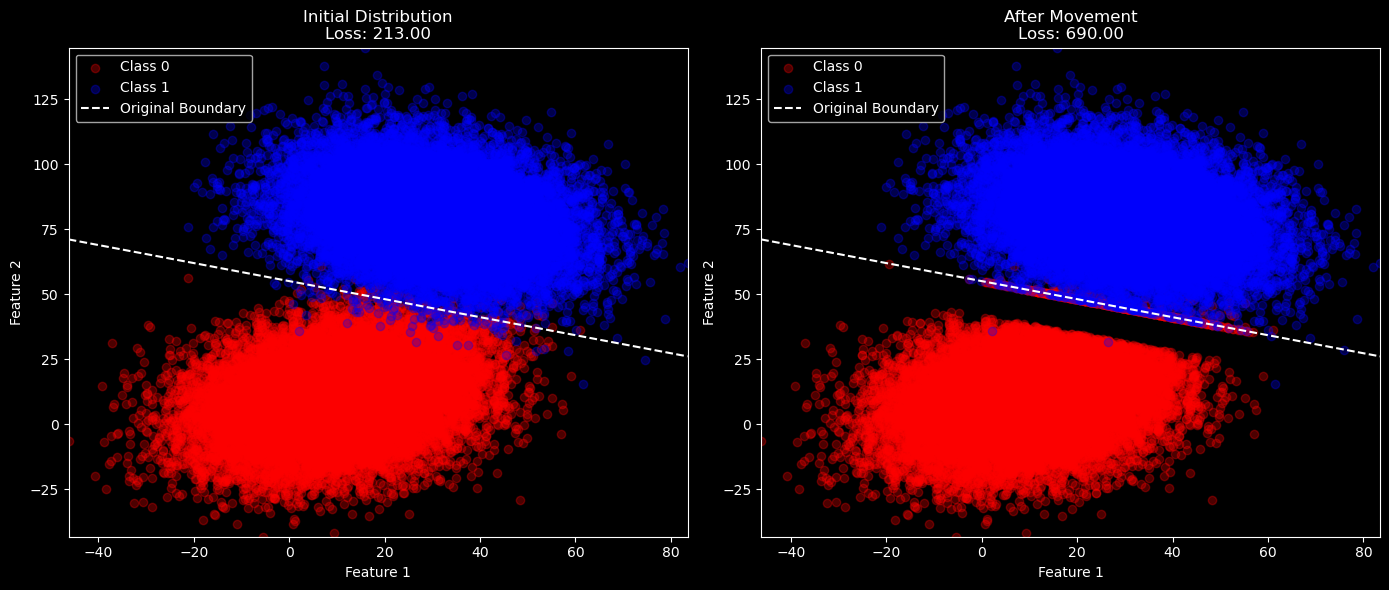

/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_6558/2610724955.py:174: UserWarning: The following kwargs were not used by contour: 'label'
  ax[0].contourf(xx, yy, f_0, cmap='Reds', alpha=0.5, label='Class 0', levels=levels)
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_6558/2610724955.py:175: UserWarning: The following kwargs were not used by contour: 'label'
  ax[0].contourf(xx, yy, f_1, cmap='Blues', alpha=0.5, label='Class 1', levels=levels)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_6558/2610724955.py:183: UserWarning: The following kwargs were not used by contour: 'label'
  ax[1].contourf(xx, yy, f_0_moved, cmap='Reds', alpha=0.5, label='Class 0', levels=levels)
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_6558/2610724955.py:184: UserWarning: The following kwargs were not

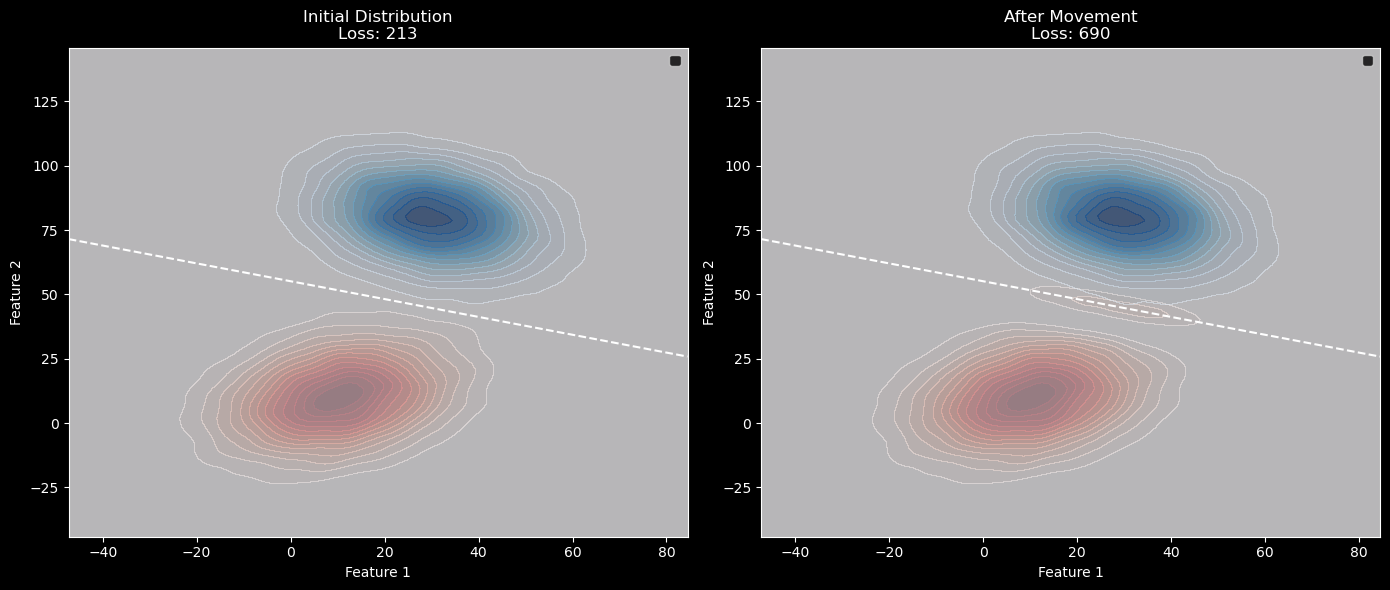

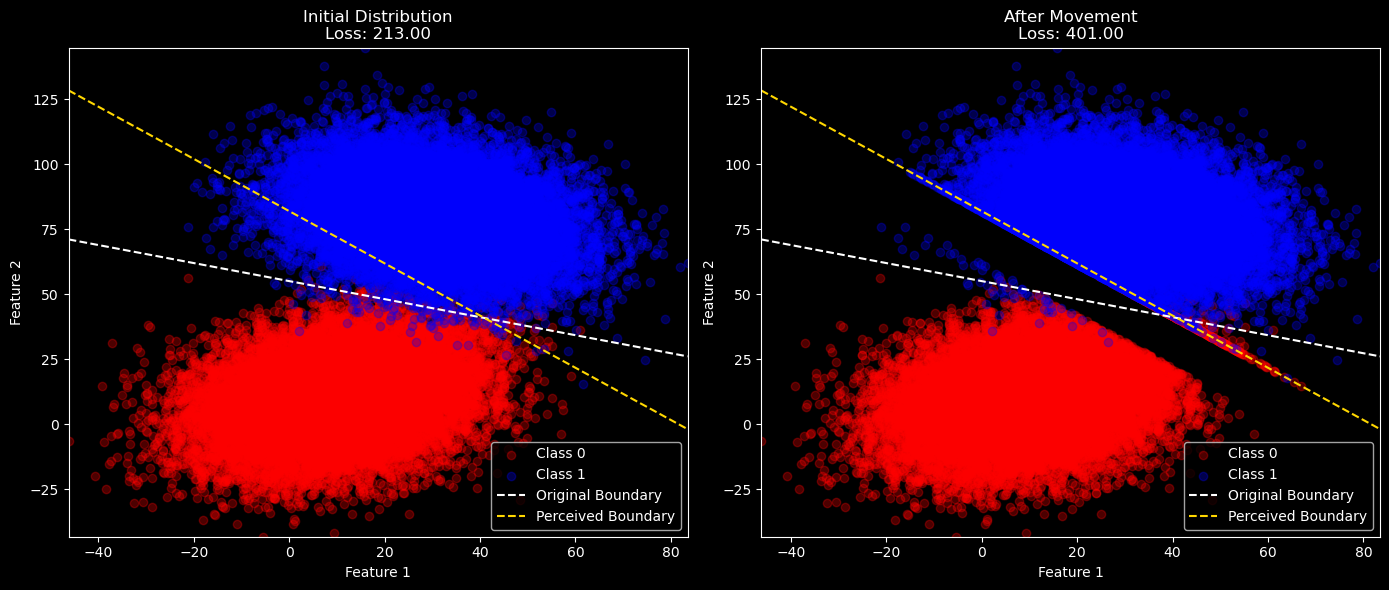

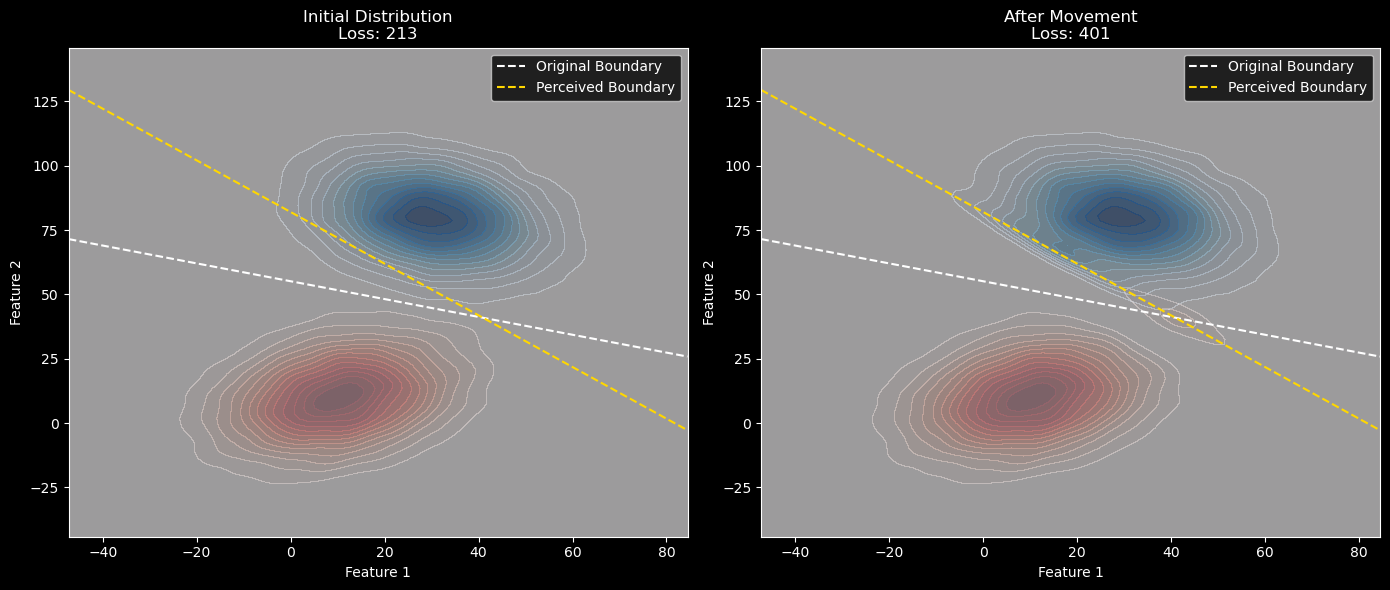

In [45]:
# Find the best decision boundary using LR
X = np.concatenate([X_0, X_1])
y = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])

beta, intercept, obj = logistic_regression_with_sum_constraint(pd.DataFrame(X), pd.Series(y))
# beta, intercept, obj = maximize_surrogate_tp_minus_fp(X, y)

print(f'Coefficients: {beta}')

a, b = beta
t = -intercept


B = 10  # Width of the region

plot_for(X_0, X_1, a, b, t, B, mode='NB')
plot_dist(X_0, X_1, a, b, t, B, mode='NB')

plot_for(X_0, X_1, a, b, t, B, mode='B', gamma=0.3)
plot_dist(X_0, X_1, a, b, t, B, mode='B', gamma=0.3)

Objective before movement: -869.7842777973428
Objective after movement: -821.3490898783157
Coefficients: [0.28644354 0.71355646]


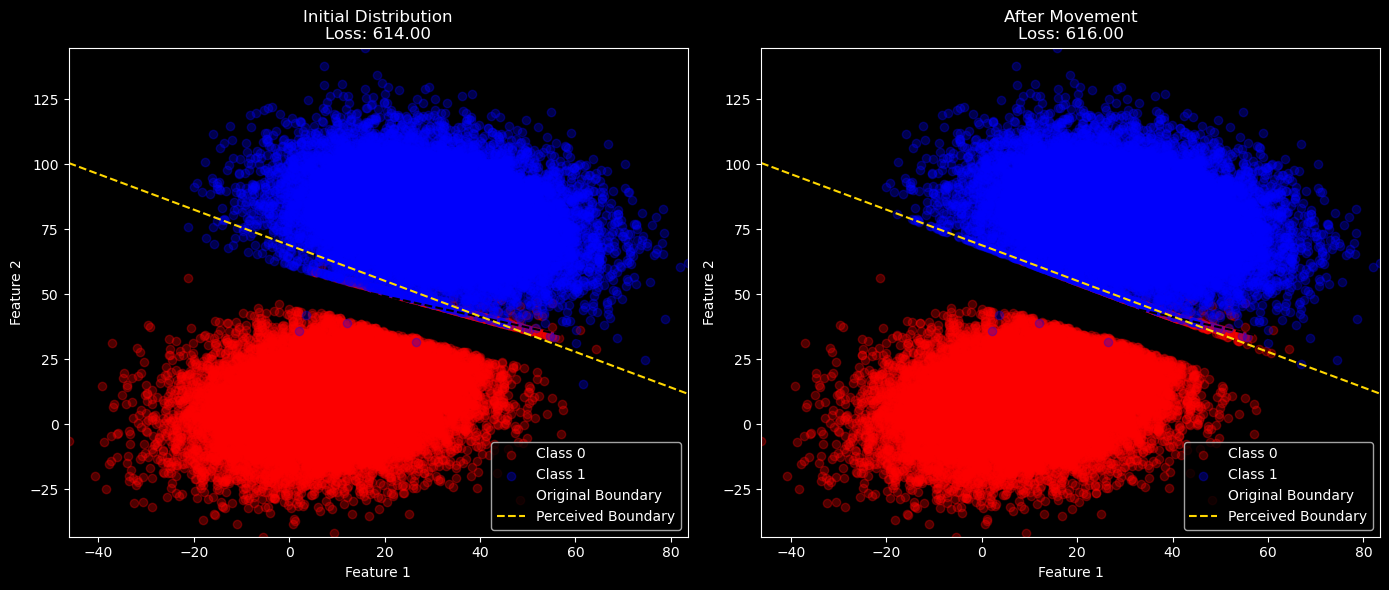

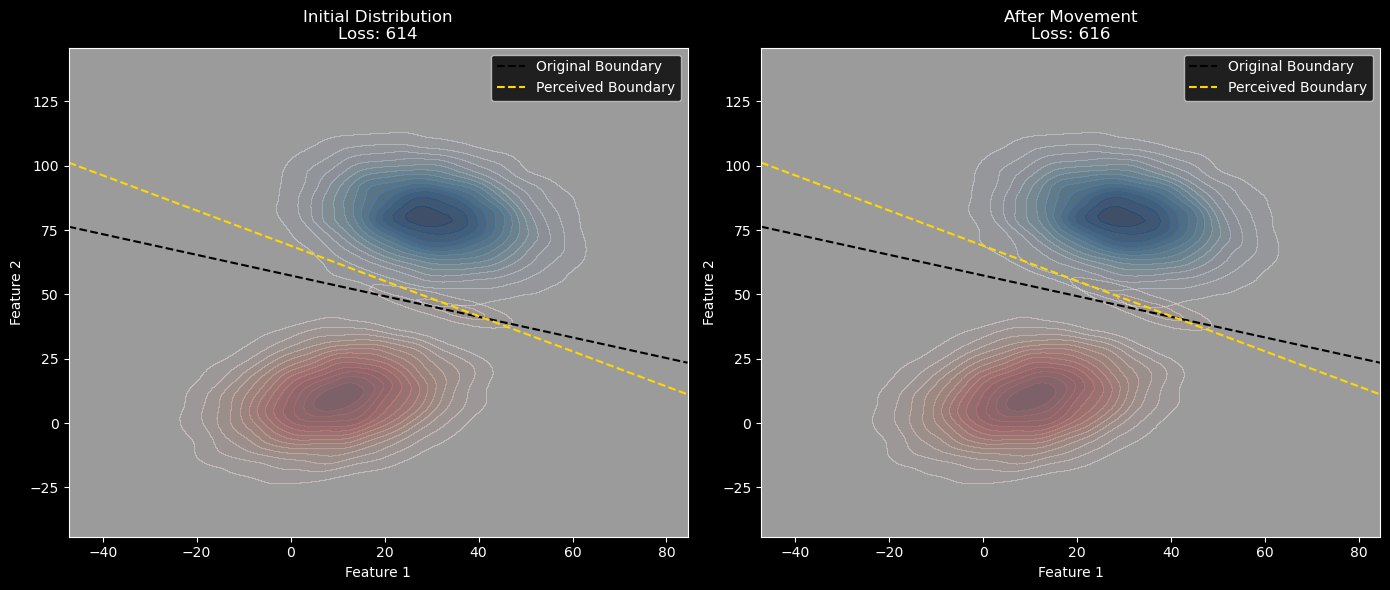

In [39]:
# Find the best decision boundary on the transformed space
a_B = w(a, 0.3)
b_B = 1 - a_B

# Movement region parameters
mask_0 = (t - B <= a_B * X_0[:, 0] + b_B * X_0[:, 1]) & (a_B * X_0[:, 0] + b_B * X_0[:, 1] < t)
mask_1 = (t - B <= a_B * X_1[:, 0] + b_B * X_1[:, 1]) & (a_B * X_1[:, 0] + b_B * X_1[:, 1] < t)

# Move the distributions
X_0_moved = X_0.copy()
X_1_moved = X_1.copy()

move_towards_boundary(X_0_moved, mask_0, a_B, b_B, t)
move_towards_boundary(X_1_moved, mask_1, a_B, b_B, t)

X_moved = np.concatenate([X_0_moved, X_1_moved])
y_moved = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])

beta_moved, intercept_moved, obj_moved = logistic_regression_with_sum_constraint(pd.DataFrame(X_moved), pd.Series(y_moved))

print(f'Objective before movement: {obj}')
print(f'Objective after movement: {obj_moved}')

print(f'Coefficients: {beta_moved}')

a_moved, b_moved = beta_moved

plot_for(X_0_moved, X_1_moved, a_moved, b_moved, t, B, mode='B')
plot_dist(X_0_moved, X_1_moved, a_moved, b_moved, t, B, mode='B')